### Imports

In [46]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
%autoreload 2

In [48]:
from IPython.display import display
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.vfm.utils.descriptive_utils import *
from src.vfm.model.hybrid.physics_informed import PhysicsInformedHybridModel
import json

In [49]:
connection = Connection()
# Get client
client = connection.get_client()

In [50]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'gl_mass_rate',
       'gl_open_ratio', 'qo_well_test', 'qg_well_test', 'qw_well_test',
       'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id'],
      dtype='object')

In [51]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [52]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Total original record count 834
W06 original record count: 137
[Non-physical filter] Rows before: 100, dropped: 2 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 1, safety floor (<75.0 Sm3/h): 0), remaining: 98
W06 Record count after preprocessing: 96
W08 original record count: 69
[Non-physical filter] Rows before: 66, dropped: 10 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 0, safety floor (<75.0 Sm3/h): 0), remaining: 56
W08 Record count after preprocessing: 46
W10 original record count: 222
[Non-physical filter] Rows before: 221, dropped: 2 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 1, safety floor (<75.0 Sm3/h): 0), remaining: 219
W10 Record count after preprocessing: 210
W11 original record count: 154
[Non-physical filter] Rows before: 119, dropped: 0 (shut-in violations: 0, open-no-flow: 0, relative collapse (< median/1000): 0, safety floor (<75.0 Sm3/h): 0), remaining: 119
W11 Record coun

690

In [53]:
df_all_wells_preprocessed["pres_drop"].describe()

count    690.000000
mean     104.564220
std        8.498281
min       66.960966
25%      100.211724
50%      103.879591
75%      109.982875
max      183.323377
Name: pres_drop, dtype: float64

In [54]:
summarize_null(df_all_wells_preprocessed)

qo_well_test      0
qg_well_test      0
qw_well_test      0
well_code         0
dhp               0
dht               0
whp               0
wht               0
choke             0
dcp               0
gl_mass_rate      0
gl_open_ratio     0
qo_mpfm          28
qg_mpfm          28
qw_mpfm          28
wc_mpfm           0
gor_mpfm         29
wgr_mpfm         30
gor_well_test     0
wgr_well_test     0
pres_drop         0
temp_drop         0
well_id           0
time_idx          0
dtype: int64

In [55]:
df_all_wells_preprocessed[df_all_wells_preprocessed["qw_well_test"] == 0]["qw_well_test"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: qw_well_test, dtype: float64

In [91]:
df_train, df_val, df_test = get_lag_safe_block_split(df=df_all_wells_preprocessed)
# df_train, df_val, df_test = get_random_train_val_test_split_per_well_temporal_order(df=df_all_wells_preprocessed)
print(f"Train={len(df_train)}, Validation={len(df_val)}, Test={len(df_test)}")

Train=483, Validation=0, Test=135


In [92]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)

In [93]:
def assert_model(hybrid_model):
    assert hasattr(hybrid_model, "_ml_feature_columns")
    assert len(hybrid_model._ml_feature_columns) > 0

    # Feature consistency check
    df_test_lag = hybrid_model._create_lagged_features(df_test).dropna()
    phys_test = hybrid_model.predict_physics(df_test_lag)

    # Feature consistency check
    X_test_df = hybrid_model._build_ml_features(df_test_lag, phys_test)
    assert list(X_test_df[hybrid_model._ml_feature_columns].columns) == hybrid_model._ml_feature_columns

In [94]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model.fit(df=df_train, df_val=df_val)
# assert_model(model)

[INFO] Regime below_normal: 48 samples
[INFO] Regime normal: 334 samples
[INFO] Regime above_normal: 94 samples


In [95]:
physics_scores = model.score_physics(df_test)
physics_scores

{'W06': {'qo': {'r2': 0.7539762280467724,
   'mae': 13.930428792937246,
   'rmse': 17.111129097008686,
   'mape (%)': 15.569428525074313,
   'mpe (%)': 1.2815440023057536},
  'qw': {'r2': -0.054686950842611104,
   'mae': 1.177439178087812,
   'rmse': 1.4320798898910974,
   'mape (%)': 448.7512045657845,
   'mpe (%)': 418.5951417183907},
  'qg': {'r2': 0.7070048533784893,
   'mae': 1863.4817040097898,
   'rmse': 2317.674578159433,
   'mape (%)': 15.279708022838676,
   'mpe (%)': -14.7406707530077},
  'wgr': {'r2': -4.5934497955169915,
   'mae': 0.00012806931141691956,
   'rmse': 0.00018522205347665154,
   'mape (%)': 650.5066826349253,
   'mpe (%)': 626.242592894952},
  'gor': {'r2': -1188.1361688149827,
   'mae': 20.081128362615672,
   'rmse': 31.9692014107512,
   'mape (%)': 16.30782523103468,
   'mpe (%)': -11.283340351044863}},
 'W08': {'qo': {'r2': -0.10397408122342,
   'mae': 7.213163150365694,
   'rmse': 8.750722278733125,
   'mape (%)': 23.668601219716106,
   'mpe (%)': -1.27363

In [96]:
hybrid_scores = model.score_hybrid(df_test)
hybrid_scores

{'W06': {'qo': {'r2': 0.9195919280468883,
   'mae': 7.738716256197472,
   'rmse': 9.794327350690097,
   'mape (%)': 7.533133582851842,
   'mpe (%)': -6.479692869657367},
  'qw': {'r2': -1.6256783490012507,
   'mae': 1.5256540757571053,
   'rmse': 2.3136203588219204,
   'mape (%)': 210.99458551151722,
   'mpe (%)': 143.4173792320035},
  'qg': {'r2': 0.9413721495140112,
   'mae': 891.0280039884852,
   'rmse': 1038.143768094,
   'mape (%)': 7.628243846919644,
   'mpe (%)': -4.101074115722257},
  'wgr': {'r2': -8.183426106916151,
   'mae': 0.00013908071482634002,
   'rmse': 0.00023037342529077409,
   'mape (%)': 248.4519824777167,
   'mpe (%)': 188.7346042900423},
  'gor': {'r2': -99.95795140408923,
   'mae': 7.526036806078421,
   'rmse': 9.564751319955992,
   'mape (%)': 6.11240250525577,
   'mpe (%)': 2.6277986125157624}},
 'W08': {'qo': {'r2': 0.44436020233197204,
   'mae': 4.928586667340346,
   'rmse': 5.7163049856705515,
   'mape (%)': 17.668021717472495,
   'mpe (%)': -0.108382468887

In [97]:
mpfm_scores = model.score_mpfm(df=df_test)
mpfm_scores

{'W06': {'qo': {'r2': 0.9847786330139957,
   'mae': 3.594811062831198,
   'rmse': 4.261393305335632,
   'mape (%)': 2.9479306418457916,
   'mpe (%)': 2.9479306418457916},
  'qw': {'r2': -0.8206548384931704,
   'mae': 1.2725593205501033,
   'rmse': 1.926571562516764,
   'mape (%)': 87.54391408127908,
   'mpe (%)': -87.38518643936658},
  'qg': {'r2': 0.9932611583595714,
   'mae': 313.7633095070478,
   'rmse': 351.9639158054769,
   'mape (%)': 2.2304510633382484,
   'mpe (%)': 2.2304510633382484},
  'wgr': {'r2': -1.2612839491393424,
   'mae': 8.310755500064854e-05,
   'rmse': 0.00011431614265924747,
   'mape (%)': 86.86462290458132,
   'mpe (%)': -86.86462290458132},
  'gor': {'r2': -2.0056937236750354,
   'mae': 1.4930356552245423,
   'rmse': 1.650348947337057,
   'mape (%)': 1.2122718385206215,
   'mpe (%)': -0.6839144809630082}},
 'W08': {'qo': {'r2': 0.9612600177815493,
   'mae': 1.4299543576292835,
   'rmse': 1.5093794338984443,
   'mape (%)': 5.402249177635214,
   'mpe (%)': 4.1034

In [98]:
# df_physics = scores_to_df(physics_scores, "Physics")
# df_hybrid  = scores_to_df(hybrid_scores,  "Hybrid")
# df_mpfm    = scores_to_df(mpfm_scores,    "MPFM")

# df_all = pd.concat([df_physics, df_hybrid, df_mpfm], ignore_index=False)

# for well in get_all_wells():
#     df_display = df_all[(df_all["well_id"] == well) & (df_all["metric"] == "r2") & (df_all["variable"].isin(["qg", "qo", "qw"]))]
#     print(df_display[["well_id", "variable", "model", "metric", "value"]].reset_index(drop=True))
    # display(
    # df_display
    # .sort_values(["well_id", "variable"])
    # )

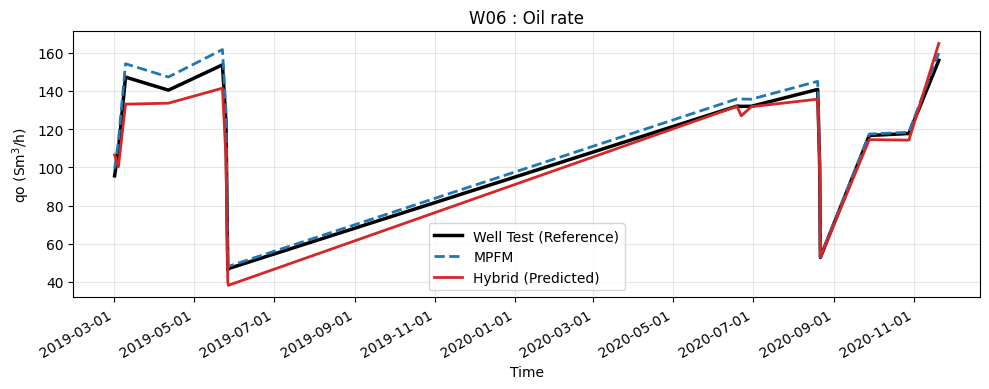

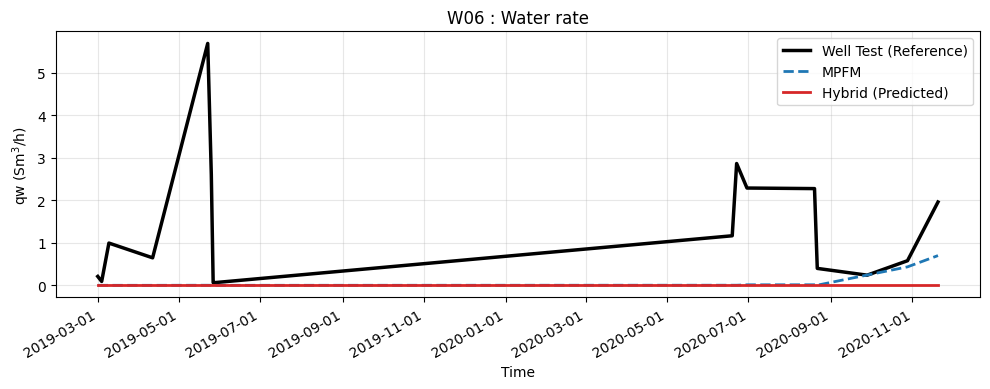

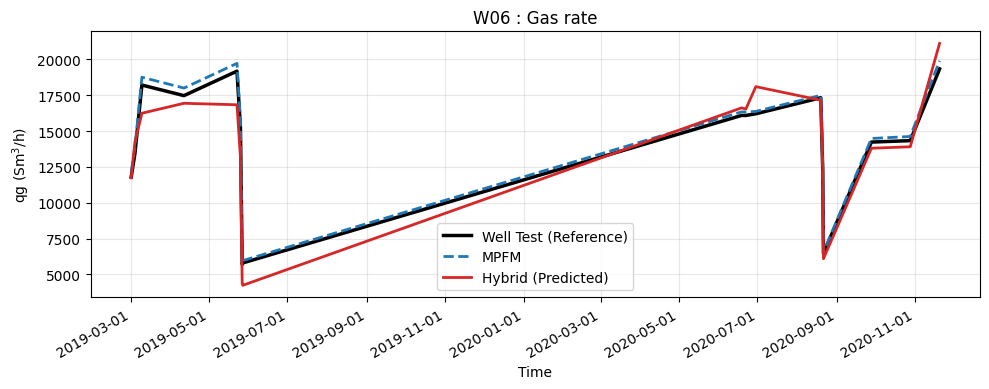

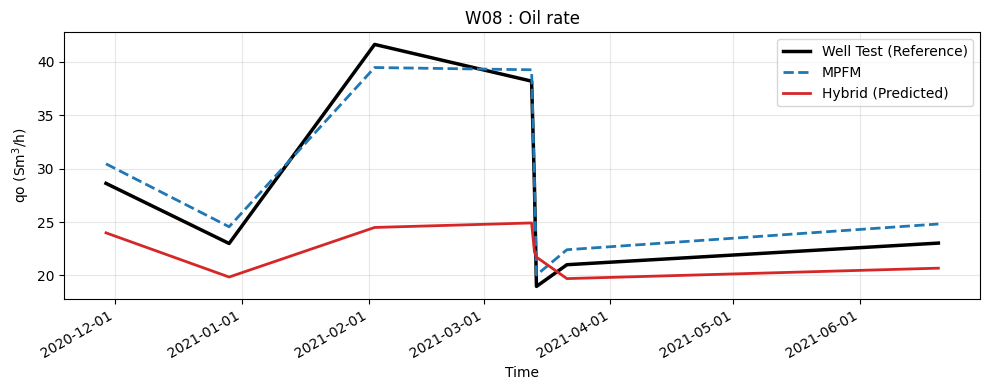

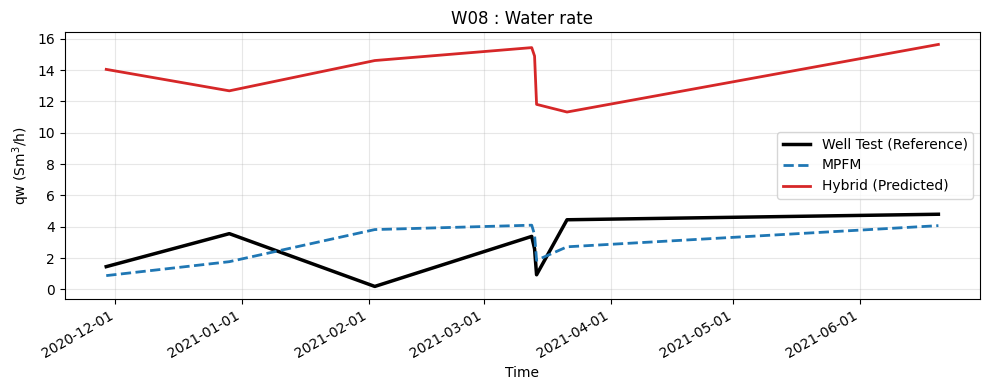

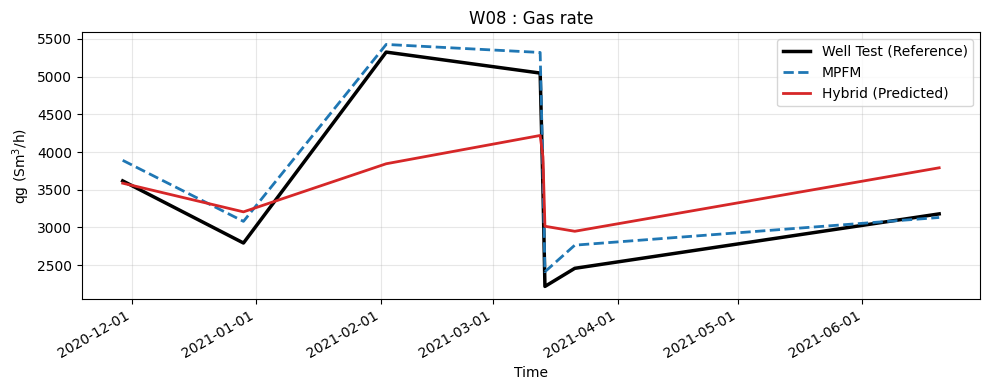

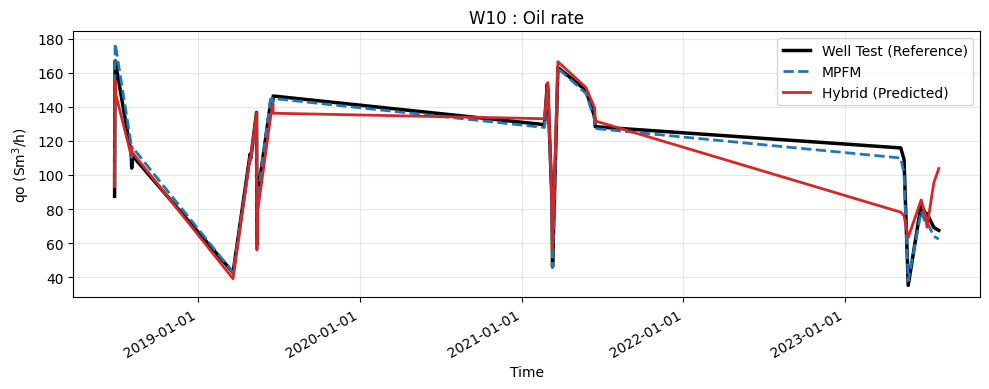

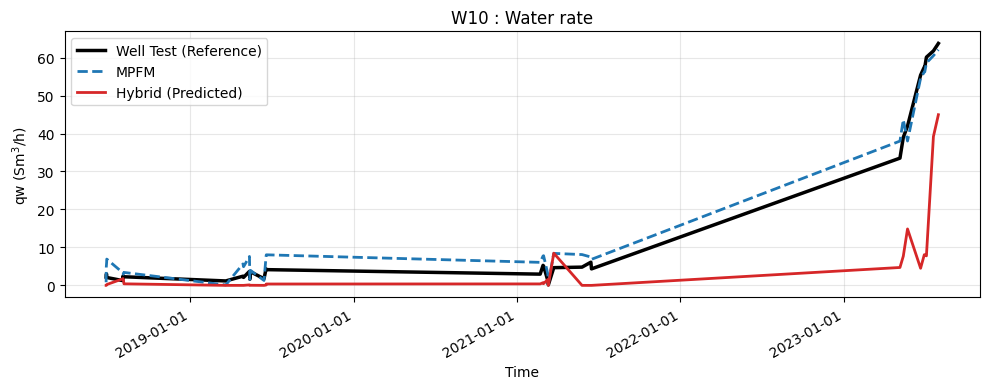

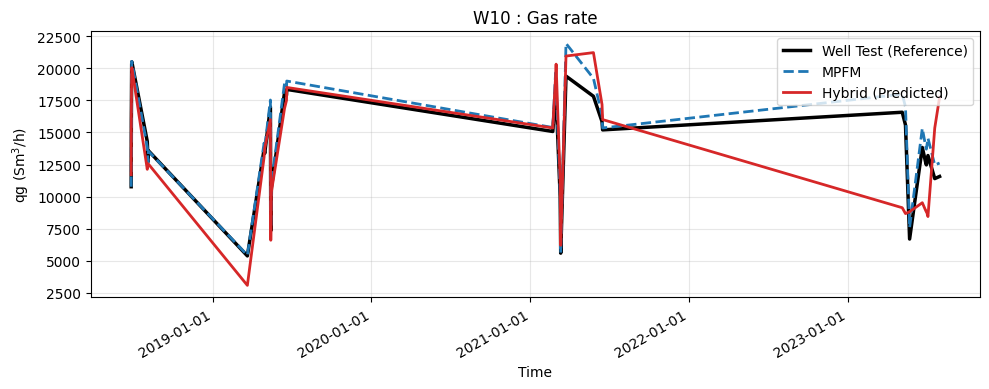

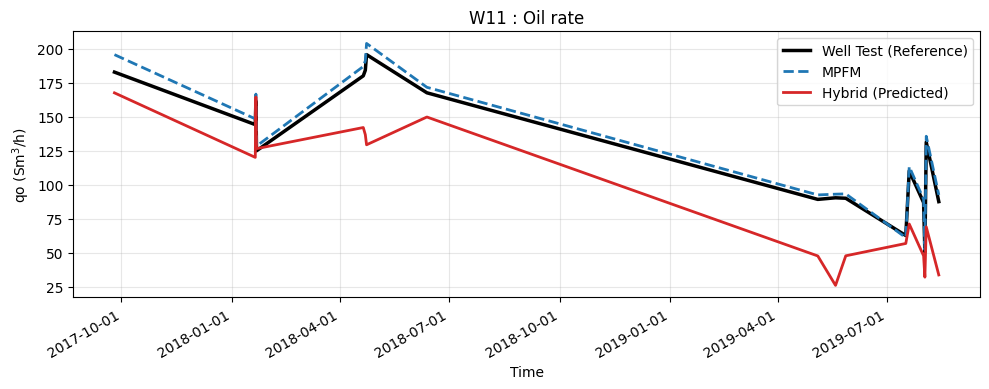

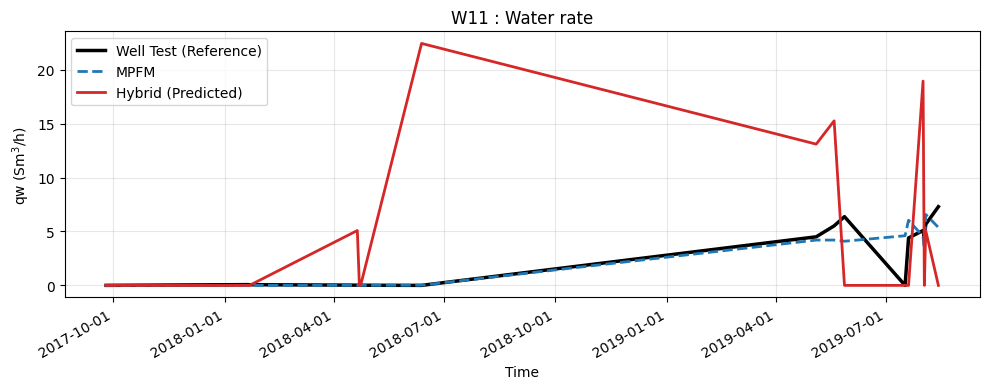

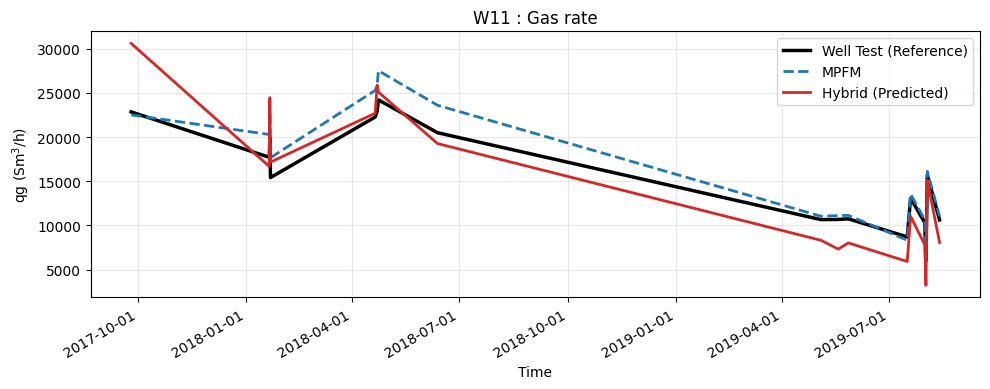

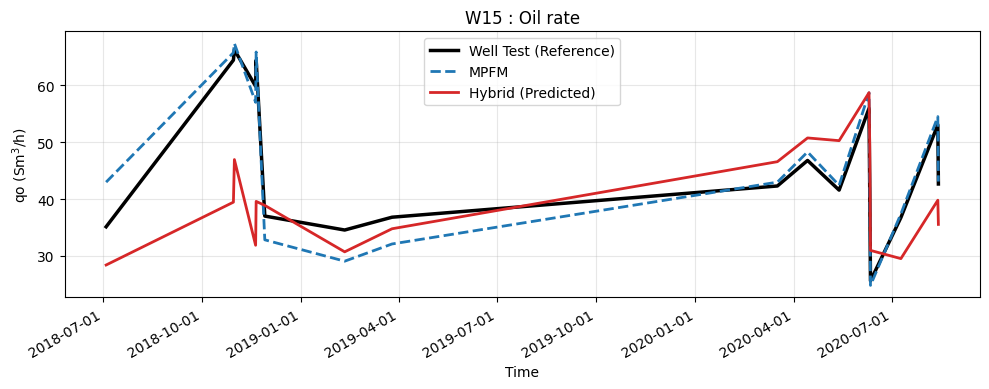

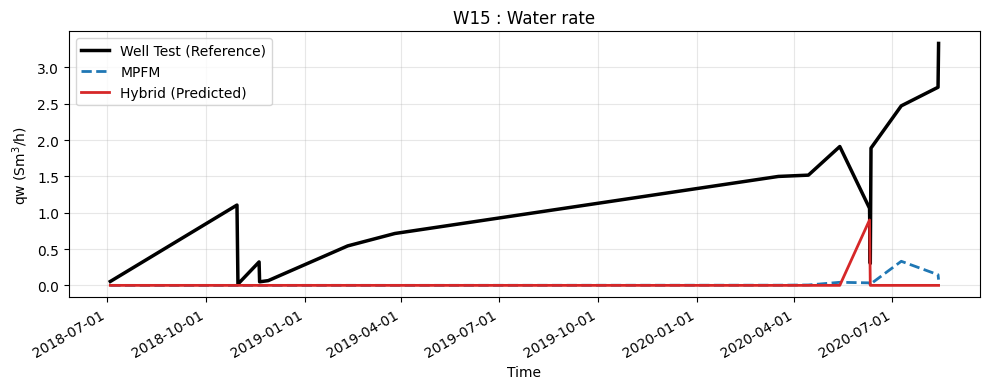

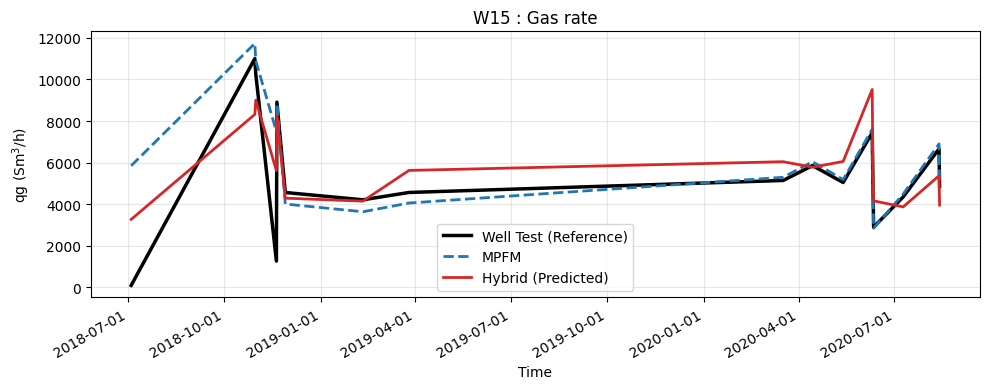

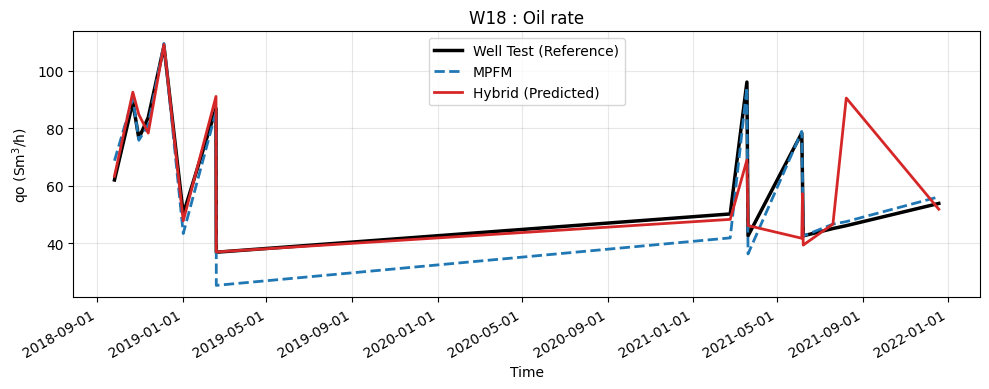

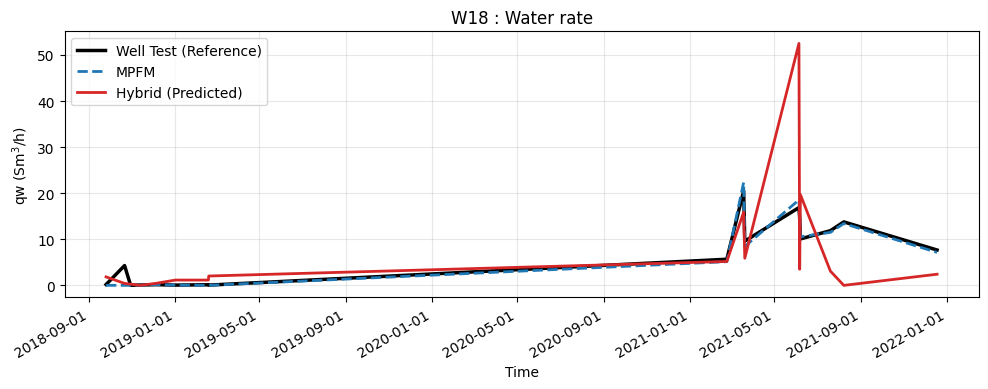

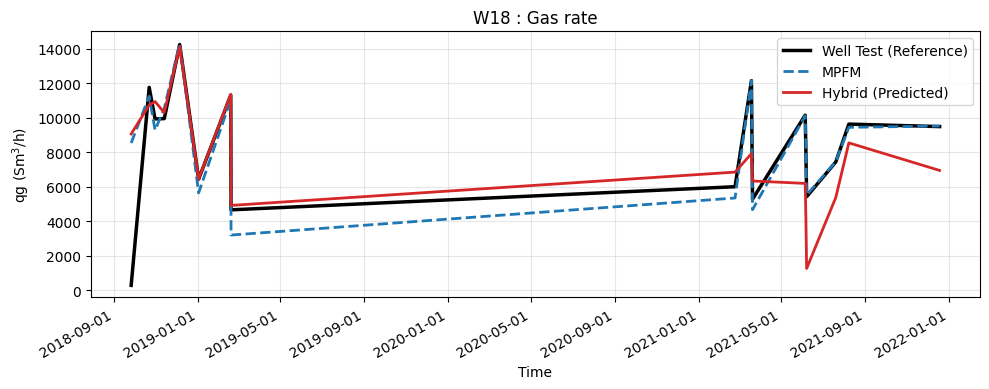

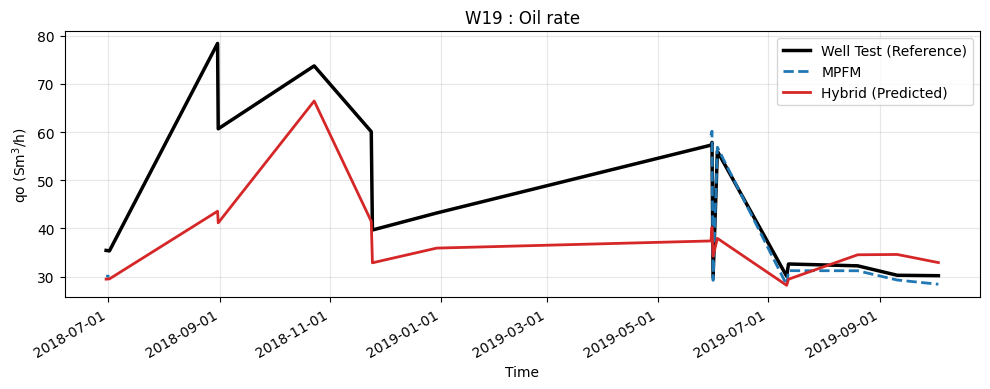

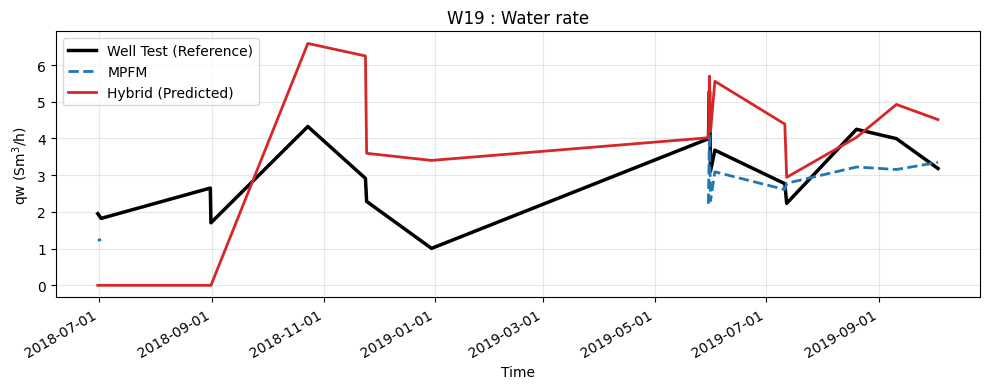

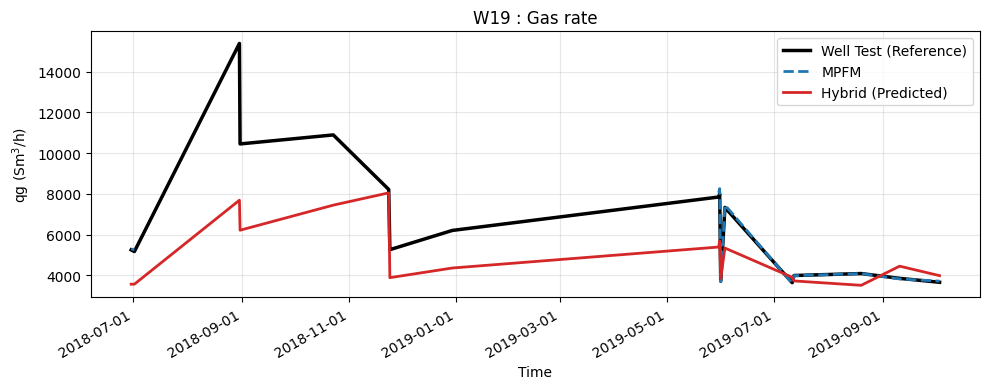

In [99]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [100]:
df_train_lowo, df_val_lowo, df_calibration_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10", split_method="blocked_temporal")
print(f"Train={len(df_train_lowo)}, Val={len(df_val_lowo)}, Calibration={len(df_calibration_lowo)}, Test={len(df_test_lowo)}")

Train=330, Val=99, Calibration=18, Test=171


In [101]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)

[INFO] Regime below_normal: 45 samples
[INFO] Regime normal: 189 samples
[INFO] Regime above_normal: 90 samples
[INFO] Validation ML usage fraction: 1.00


In [102]:
model_lowo.calibrate_physics_only(df=df_calibration_lowo)
assert_model(model_lowo)

In [103]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': 0.16687335223980093,
   'mae': 17.86830396876308,
   'rmse': 30.309747293256965,
   'mape (%)': 20.054547107517344,
   'mpe (%)': 12.27843665487181},
  'qw': {'r2': 0.15288696015482328,
   'mae': 3.318204771063875,
   'rmse': 10.464863208510486,
   'mape (%)': 52992.841838452885,
   'mpe (%)': 52957.23794587293},
  'qg': {'r2': 0.32350973964262975,
   'mae': 2680.542730157272,
   'rmse': 3323.8538881421714,
   'mape (%)': 20.632010057473828,
   'mpe (%)': -11.422464564391236},
  'wgr': {'r2': -1.630382291926035,
   'mae': 0.0004971416245303296,
   'rmse': 0.0016183448484263267,
   'mape (%)': 227.09814746999425,
   'mpe (%)': 195.82491285130192},
  'gor': {'r2': -14.41713065902175,
   'mae': 28.20536497961276,
   'rmse': 41.09045249245952,
   'mape (%)': 22.12346190033271,
   'mpe (%)': -15.33642211014147}},
 'GLOBAL': {'qo': {'r2': 0.16687335223980093,
   'mae': 17.86830396876308,
   'rmse': 30.309747293256965,
   'mape (%)': 20.054547107517344,
   'mpe (%)': 12.

In [104]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.6844330875401006,
   'mae': 13.922922171084476,
   'rmse': 18.68868607806123,
   'mape (%)': 13.140366895265215,
   'mpe (%)': -6.11995573102734},
  'qw': {'r2': -0.024824418052422192,
   'mae': 5.584075404545386,
   'rmse': 11.536048104637334,
   'mape (%)': 63893.783099112225,
   'mpe (%)': 63762.672309465066},
  'qg': {'r2': 0.6375486606675322,
   'mae': 1837.1179598382373,
   'rmse': 2437.5845089134764,
   'mape (%)': 15.187914211958672,
   'mpe (%)': 0.44176035432459193},
  'wgr': {'r2': -0.07124505141184767,
   'mae': 0.00044921835989846014,
   'rmse': 0.0010327757880942167,
   'mape (%)': 147.09714663956302,
   'mpe (%)': 14.39803639143351},
  'gor': {'r2': -9.98875205911252,
   'mae': 25.424394376599594,
   'rmse': 34.79093062161919,
   'mape (%)': 20.334678740277944,
   'mpe (%)': 8.50146897583111}},
 'GLOBAL': {'qo': {'r2': 0.6844330875401006,
   'mae': 13.922922171084476,
   'rmse': 18.68868607806123,
   'mape (%)': 13.140366895265215,
   'mpe (%)': -

In [105]:
model_lowo.score_mpfm(df=df_test_lowo)

{'W10': {'qo': {'r2': 0.9580876749838309,
   'mae': 4.017149087177777,
   'rmse': 6.8587051514248225,
   'mape (%)': 3.3665238313437906,
   'mpe (%)': 0.753478777941126},
  'qw': {'r2': 0.9331261844110504,
   'mae': 2.543740691685038,
   'rmse': 2.9781353987485226,
   'mape (%)': 99892.51809223446,
   'mpe (%)': 99880.3474862487},
  'qg': {'r2': 0.954243106445226,
   'mae': 501.90399281285664,
   'rmse': 871.6137704585041,
   'mape (%)': 3.4460031665768316,
   'mpe (%)': 2.77057777165189},
  'wgr': {'r2': 0.9519876074364355,
   'mae': 0.00017398612411911025,
   'rmse': 0.00022045117808034852,
   'mape (%)': 89.93954290608347,
   'mpe (%)': 76.43144822866648},
  'gor': {'r2': 0.2701096726147323,
   'mae': 7.039037491924913,
   'rmse': 9.068642963775268,
   'mape (%)': 5.501639510731391,
   'mpe (%)': 2.21614426967231}},
 'GLOBAL': {'qo': {'r2': 0.9580876749838309,
   'mae': 4.017149087177777,
   'rmse': 6.8587051514248225,
   'mape (%)': 3.3665238313437906,
   'mpe (%)': 0.7534787779411

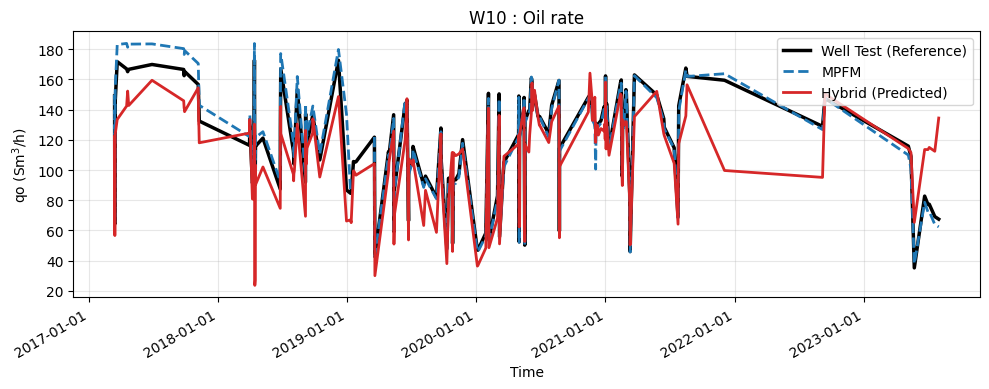

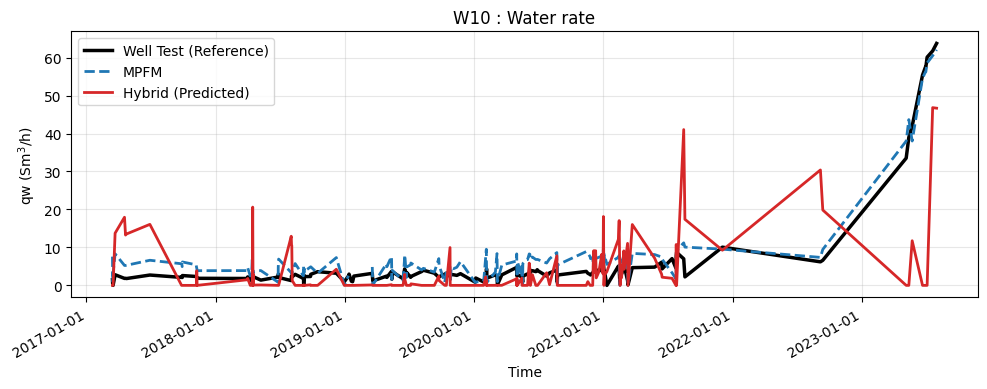

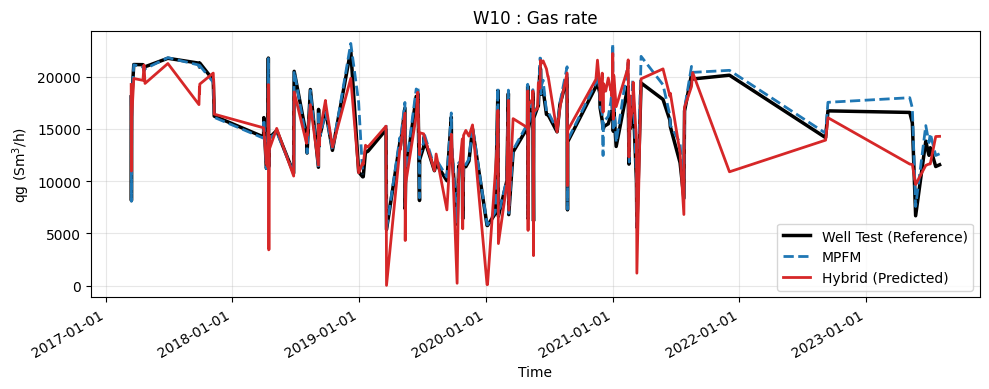

In [106]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [107]:
# resampler = Resampler()
# df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
# print(summarize_null(df=df_resampled))
# print(df_resampled.shape)

In [108]:
# df_resampled.index

In [109]:
# df_resampled.columns

In [110]:
# df_resampled[df_resampled["is_observed"] == 1].shape

In [111]:
# Monotonic
# df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

In [112]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [113]:
# summarize_null(df_generated)